<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:#96c29a">Decision Tree</span></h1>
<hr>

<center>

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)


Decision Tree o árbol de decisión es un algoritmo supervisado de Machine Learning basado en el árbol de decisión tradicional, el cual es un mapa de posibles resultados de una serie de decisiones relacionadas. Esto nos permite comparar posibles acciones entre si según costos, probabilidades, costos y beneficios. Este algoritmo es altamente utilizado en la industria para conocer la decisión de un usuario en base a sus categorías, por ejemplo Netflix al recomendarte una pelicula, los mismo ocurre con Google para recomendarte productos en forma de propaganda. En el campo de la medicina, este algoritmo puede ser utilizado para saber si un fármaco es de utilidad o no contra el Covid 19.



En esta oportunidad trabajaremos con el Dataset Titanic de Kaggle, el cual es muy común y con el cual muchas personas comienzan a aprender Machine Learning. Este Dataset forma parte de una competencia de Kaggle, en el que usando Machine Learning tienes que crear un modelo que prediga que pasagero sobrevivio al naufragio del Titanic. Para solucionar este problema, usaré arboles de decisión y analizare la eficiencia.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pydotplus
from io import StringIO
from IPython.display import Image, display
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# 1. Análisis y limpieza de los datos

Antes de realizar cualquier anáslis, es necesario comprender con que datos nos encontramos trabajando, Kaggle nos ayuda en esto, dandonos algunas caracteristicas de nuetros datos los cuales mencionaremos a continuación. 

In [ ]:
df = pd.read_csv('./Datasets/Titanic.csv')
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
628,629,0,3,"Bostandyeff, Mr. Guentcho",male,26.0,0,0,349224,7.8958,NaN,S
107,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S
711,712,0,1,"Klaber, Mr. Herman",male,NaN,0,0,113028,26.5500,C124,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C
287,288,0,3,"Naidenoff, Mr. Penko",male,22.0,0,0,349206,7.8958,NaN,S
447,448,1,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,NaN,S
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.2250,NaN,S
387,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
740,741,1,1,"Hawksford, Mr. Walter James",male,NaN,0,0,16988,30.0000,D45,S


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


con la información de las columnas y tipos de datos de nuestro dataset, logramos identificar que cabin, age y Embarked contienen datos nulos, los cuales trabajaremos a continuación. Para el caso del sexo,llenaremos los datos nulos con la media de esta columna.

In [ ]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df[df['Age'].isnull()] # al mostrar esto en pantalla podemos apreciar que no existen valores dentro de la columna age con datos nulos

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Otra columna con datos nulos era Embarket, al ser una variable categorica, llenare estos datos faltantes con el dato que más se repite, para esto utilizo describe el cual me dara este valor en el indice top.

In [ ]:
df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [ ]:
df['Embarked'] = df['Embarked'].fillna('S')
df[df['Embarked'].isnull()] #verificando que se llenaron todos los datos  nulos

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Para el caso de Cabin, vemos que los datos nulos son más de la mitad, por ello, lo mejor que podemos hacer es no considerarlo dentro de nuestro análisis.

# 2. Preprocesamiento

Una vez que culminamos de realizar la limpieza de nuestros datos, pasaremos a decidir con que features de nuestro dataset nos quedaremos para realizar un correcto análisis y obtener buenos resultados. Para esta selección primero definiremos que condiciones debe de cumplir una columna para ser categorizada como variable categorica o numerica, ya que estos dos tipos de features serán los que nos brinden mayor información para nuestro entrenamiento. posterior a esta definición de la condición crearemos una variable que contiene los nombres de las columnas admitidas para hacerla filtración de nuestro dataset.

La selección realizada antreriormente fue hecha al ojo y piede que ciertas features se nos hallan escapado, para una mejor selección clasificaremos las columnas por númericas y categoricas que son los principales tipos de datos que nos brindaran información para entrenar nuestro modelo.

In [ ]:
categorical_cols = [cname for cname in df.columns if df[cname].nunique()<10 and df[cname].dtype=='object']
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

In [ ]:
my_correct_cols = categorical_cols + numerical_cols
train_predictors = df[my_correct_cols]
train_predictors.shape

(891, 9)

In [ ]:
train_predictors.sample(5)

,Sex,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
226,male,S,227,1,2,19.0,0,0,10.5
386,male,S,387,0,3,1.0,5,2,46.9
241,female,Q,242,1,3,28.0,1,0,15.5
55,male,S,56,1,1,28.0,0,0,35.5
72,male,S,73,0,2,21.0,0,0,73.5


De nuestros datos filtrados podemos ver que Survived es parte del target, por ello debemos eliminarlo y PassengerId no nos brinda mucha información para hacer nuestro modelo, por ello tambien lo eliminamos.

In [ ]:
train_predictors = train_predictors.drop(['PassengerId', 'Survived'], axis=1)

In [ ]:
train_predictors.head(5)

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,S,3,22.0,1,0,7.2500
1,female,C,1,38.0,1,0,71.2833
2,female,S,3,26.0,0,0,7.9250
3,female,S,1,35.0,1,0,53.1000
4,male,S,3,35.0,0,0,8.0500


Como sabemos las variables categoricas no son de mucha a utilidad como string al momento del entrenamiento, nuestro modelo necesita trabajar con valores númericos, para ello, lo mejor que podemos hacer es convertir estas variables categoricas a variables númericas (Es decir una coficiación), esto lo haremos mediante el método dummie que nos ofrece pandas, además,aumentaremos la dimensionalidad de nuestro DataFrame.

In [ ]:
dummy_encoded_train_predictors = pd.get_dummies(train_predictors)

In [ ]:
dummy_encoded_train_predictors.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


# 3. Implementación del modelo

Para realizar la implementación del modelo, lo primero que debemos hacer es divir el target que seria la columna Survived y la columna de nuestras features que ya lo hemos preparado previamente.

In [ ]:
y_target = df['Survived'].values
x_features = dummy_encoded_train_predictors.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=1)

Una vez hecha la división pasamos a definir nuestro modelo y entrenarlo

In [ ]:
model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)

análizamos la precisión de nuestro modelo.

In [ ]:
model_accuracy = round(model.score(X_test, y_test), 3)
print('Acurracy:%0.3f'%(model_accuracy))

Acurracy:0.757


In [ ]:
out = StringIO()
export_graphviz(model, out_file=out)

graph = pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png('titanic.png')

True

<center>

![Picture title](titanic.png)
</center>

In [ ]:
predicciones = model.predict(X=X_test)
rms = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
print('Error:%0.4f'%(rms))

Error:0.4925


In [ ]:
cnf_matriz = confusion_matrix(y_test, predicciones)
cnf_matriz

array([[129,  24],
       [ 41,  74]])

Text(0.5, 257.44, 'Etiqueta de predicción')

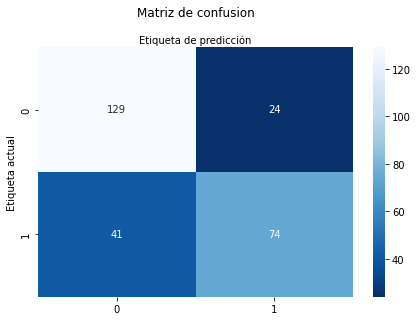

In [ ]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matriz), annot=True, cmap='Blues_r', fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Matriz de confusion', y=1.1)
plt.ylabel('Etiqueta actual')
plt.xlabel('Etiqueta de predicción')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ae02d810-34d9-4474-8459-42c689340f39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>